## Clasificación con SVM y kNN del nivel de propagación epidémica de COVID-19

### Virulencia vs P-hosp


### I. Importación de módulos.

In [2]:
import pandas as pd # para manipulación de datos. 
import numpy as np # álgebra lineal

#importamos paquetes de visualización de datos.
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
# generación de gráficos
%pylab inline 
pylab.rcParams['figure.figsize'] = (10, 6) #fijamos el tamaño predeterminado de las figuras

# para el preprocesamiento de datos con los que se
# correran ambos algoritmos
from sklearn.model_selection import train_test_split # partición de conjuntos
from sklearn.preprocessing import StandardScaler # escalamiento de variables

#para SVM
from sklearn.svm import SVC
#para kNN
from sklearn.neighbors import KNeighborsClassifier

#para optimización
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#para crear matrices de confusión
from sklearn.metrics import confusion_matrix



Populating the interactive namespace from numpy and matplotlib


### II. Carga del dataset, variables y clases. 


#### II.1 Dataset.
El dataset es el archivo ```LOG-complete-clasificacion.csv```, pero con la variable  `Escenario` renombrada numéricamente para los distintos Niveles de propagación (NvProp). 

In [3]:
data = pd.read_csv("LOG-complete-clasificacion-nvprop-num.csv")
print(data.shape)
data.head()


(280, 11)


,Incidencia,Virulencia,P-hosp,Letalidad,Acumulado hosp,sDist,N decesos infeccion,N decesos hosp,Acumulado defunciones,atpi,NvProp
0,0.345663,0.186916,0.079291,0.034177,5674,1976194036,763,414,1177,13979028,4
1,0.349166,0.183824,0.077651,0.033191,5539,1977327825,725,406,1131,13506194,4
2,0.345475,0.189153,0.080286,0.032014,5765,1987557951,687,405,1092,12880123,4
3,0.346643,0.182750,0.077771,0.032577,5639,1980234041,745,393,1138,13534679,4
4,0.343393,0.185834,0.080597,0.030944,5785,1986763877,677,399,1076,13112181,4


#### II.2 Clases

La variable respuesta es el Nivel de Propagación (```NvProp```) y, en este caso, las clases son numéricas, siendo:

* **1: NvProp Bajo**
* **2: NvProp Intermedio**
* **3: NvProp Alto**
* **4: NvProp Muy Alto**

In [5]:
print("Observaciones por Nivel de Propagación:\n", data['NvProp'].value_counts())


Observaciones por Nivel de Propagación:
 4    70
3    70
2    70
1    70
Name: NvProp, dtype: int64


In [6]:
y = data.loc[:, ['NvProp']]
print('\n' + 'Las clases en este dataset son\n\n' + str(np.unique(y)))
print('\n' + 'Niveles de propagación')


Las clases en este dataset son

[1 2 3 4]

Niveles de propagación


#### II.3 Variables

Por su parte, en X se encuentran las variables epidemiológicas que estarán involucradas en el algoritmo de 
clasificación. Para su fácil selección, la tabla a cotinuación muestra en qué índice se encuentra cada variable. 

| Variable      | Índice |
| --------------|--------|
| Incidencia    |   0    |
| Virulencia    |   1    |
| P-hosp        |   2    |
| Letalidad     |   3    |
| Acumulado hosp|   4    | |
| sDist         |   5    |
| N decesos inf |   6    |
| N decesos hosp|   7    |
| Acumulado def |   8    |
| atpi          |   9    |



In [8]:
#en este caso, tomaremos los índices correspondientes a las variables
# P-hosp, para el eje de las abscisas
# Virulencia en el eje de las ordenadas
# Establecer los valores de Ax y Ab para introducrilos cuando sea necesario obtener valores de X
Ax = 2
Ay = 1
X = data.iloc[:, [Ax, Ay]]
print(X.shape)
X.head()


(280, 2)


,P-hosp,Virulencia
0,0.079291,0.186916
1,0.077651,0.183824
2,0.080286,0.189153
3,0.077771,0.182750
4,0.080597,0.185834


In [10]:
# Generamos una función de visualización de datos
# con una gráfica de dispersión
def dispersion(X, y):
    # Guardamos los nombres para los ejes
    etiquetaX = X.columns[0]
    etiquetaY = X.columns[1]
    
    # Luego, Ambas variables, las convertiremos a objetos de tipo arreglo de numpy
    X = np.asarray(X)
    y = y['NvProp'].values.tolist()
    markers = ('o', '^', 'v', 'x')
    colors = ('lightblue', 'lightgreen', 'yellow', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], c=cmap(idx), marker=markers[idx], label=cl)
        plt.xlabel('{}'.format(etiquetaX))
        plt.ylabel('{}'.format(etiquetaY))
        plt.title('Gráfica de dispersión')
    #plt.savefig('Clas_Disp_{0}-{1}.png'.format(etiquetaY, etiquetaX))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

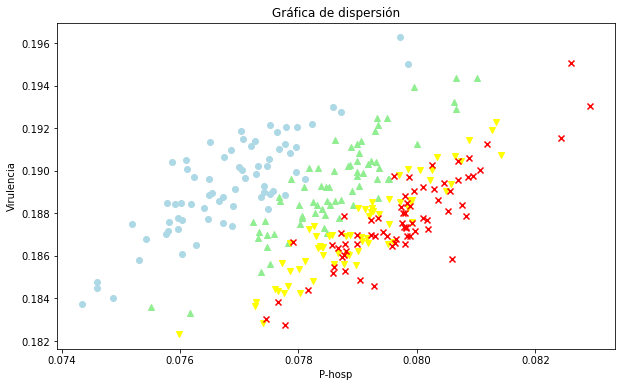

In [11]:
dispersion(X,y)

### III. Preparación de datos

In [13]:
# Para el algoritmo SVM
X_svm = X
# Para el algoritmo kNN
X_knn = X
print(X_svm.shape)

(280, 2)


#### III.1 Conjuntos de entrenamiento y prueba. 

El tamaño del conjunto prueba es $1/3$ del dataset.

In [15]:
# Para el algoritmo SVM
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y, test_size=0.33, random_state=0)
# Para el algoritmo kNN
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.33, random_state=0)

In [16]:
# Imprimimos el contenido de cada dataset
#imprimimos el contenido de cada dataset
print('----SVM-----')
print('Hay {} muestras en el set de entrenamiento y {} muestras en el set de prueba'.format(
X_train_svm.shape[0], X_test_svm.shape[0]))
print('\n----kNN-----')
print('Hay {} muestras en el set de entrenamiento y {} muestras en el set de prueba'.format(
X_train_knn.shape[0], X_test_knn.shape[0]))

----SVM-----
Hay 187 muestras en el set de entrenamiento y 93 muestras en el set de prueba

----kNN-----
Hay 187 muestras en el set de entrenamiento y 93 muestras en el set de prueba


#### III.2 Escalamiento de características/variables (estandarización)

In [17]:
sc = StandardScaler()
sc_svm = sc.fit(X_train_svm)
sc_knn = sc.fit(X_train_knn)

'''Estandarización'''

X_train_svm_std = sc_svm.transform(X_train_svm)
X_test_svm_std = sc_svm.transform(X_test_svm)

X_train_knn_std = sc_knn.transform(X_train_knn)
X_test_knn_std = sc_knn.transform(X_test_knn)

# Muestra los datos estandarizados
print('Después de la estandarización de variables,\nel conjunto de entrenamiento se observa así:\n')
pd.DataFrame(X_train_svm_std, columns = X.columns).head()

Después de la estandarización de variables,
el conjunto de entrenamiento se observa así:



,P-hosp,Virulencia
0,-0.162745,-0.968710
1,0.393892,-0.148183
2,0.857934,-0.346271
3,0.365289,-0.210827
4,-0.772890,1.541184


### IV. Ejecución de clasificadores. 

Ejecuión de clasificadores sin optimizar. 

#### IV.1. Clasificador SVM (sin optimizar).

In [27]:
#svm = SVC(kernel='rbf', random_state=0, gamma=.1, C=1.0) # 'rbf' = radial basis function
svm = SVC(kernel='linear', random_state=0, gamma=.1, C=1000)
svm.fit(X_train_svm_std, y_train_svm)

print('La precisión del clasificador SVM con los datos de entrenamiento, es {:.2f} de 1'.format(svm.score(X_train_svm_std, y_train_svm)))
print('La precisión del clasificador SVM con los datos de prueba, es {:.2f} de 1'.format(svm.score(X_test_svm_std, y_test_svm)))

La precisión del clasificador SVM con los datos de entrenamiento, es 0.80 de 1
La precisión del clasificador SVM con los datos de prueba, es 0.81 de 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


####  IV.2. Visualización de las regiones de decisión. 

Creamos primero el algoritmo de visualización.

In [25]:
#import warnings 

def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Guardamos los nombres para los ejes
    print('Ingresa el nombre del eje X\n')
    etiquetaX = input()
    print('\nIngresa el nombre del eje Y\n')
    etiquetaY = input()
    print('\n¿Se ha optimizado el clasificador?\n SI = 1\n NO = 0')
    #esto solo es para  efectuar el etiquetado correcto del nombre de la imagen
    op = input()
    
    if str(type(classifier)) == "<class 'sklearn.neighbors._classification.KNeighborsClassifier'>" and op == '0':
        name = "kNN NON-Op"
    elif str(type(classifier)) == "<class 'sklearn.svm._classes.SVC'>" and op == '0':
        name = "SVM NON-Op"
    elif str(type(classifier)) == "<class 'sklearn.neighbors._classification.KNeighborsClassifier'>" and op == '1':
        name = "kNN OPT"
    elif str(type(classifier)) == "<class 'sklearn.svm._classes.SVC'>" and op == '1':
        name = "SVM OPT"

    #ambas variables, las convertiremos a objetos de tipo arreglo de numpy
    X = np.asarray(X)
    y = y['NvProp'].values.tolist()
    
    # setup marker generator and color map
    #markers = ('s', 'x', 'o', '^', 'v')
    #colors = ('red', 'yellow', 'lightgreen', 'lightblue', 'cyan')
    markers = ('o', '^', 'v', 'x', 's')
    colors = ('lightblue', 'lightgreen', 'yellow', 'red', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.xlabel('{0} [estandarizada]'.format(etiquetaX))
    plt.ylabel('{0} [estandarizada]'.format(etiquetaY))
    plt.title('{0}\nRegión de decisión [estandarizada]'.format(name))

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
    filelabel = "_{0}-{1}".format(etiquetaY, etiquetaX)
    plt.savefig("RES_{0}_{1}.png".format(name, filelabel))
    #print("----IMPORTANTE----\nRevise la carpeta destino de la figura guardada\npara modificar manualmente el nombre y evitar que se sobreescriba.")

Ingresa el nombre del eje X

P-hosp

Ingresa el nombre del eje Y

Virulencia

¿Se ha optimizado el clasificador?
 SI = 1
 NO = 0
1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

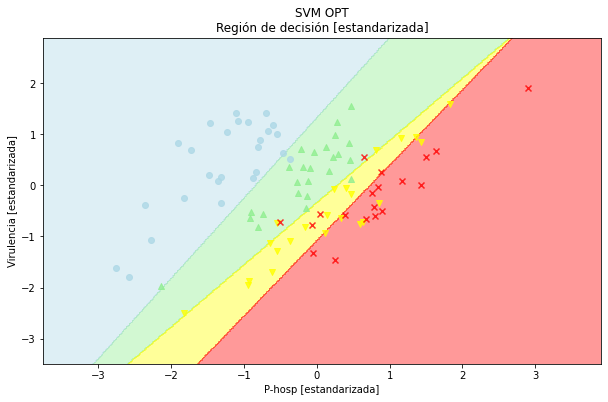

In [28]:
# graficamos las regiones de decisión para el clasificador SVM
# sin optimización
plot_decision_regions(X_test_svm_std, y_test_svm, svm)

#### IV.3. Clasificador kNN (sin optimizar).

In [32]:
knn = KNeighborsClassifier(n_neighbors=1, p=4, metric='minkowski')
knn.fit(X_train_knn_std, y_train_knn)

print('La precisión del clasificador kNN es {:.2f} de 1 en el set de entrenamiento'.format(knn.score(X_train_knn_std, y_train_knn)))
print('La precisión del clasificador kNN es {:.2f} de 1 en el set de prueba'.format(knn.score(X_test_knn_std, y_test_knn)))

La precisión del clasificador kNN es 1.00 de 1 en el set de entrenamiento
La precisión del clasificador kNN es 0.80 de 1 en el set de prueba


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Visualización de las regiones de decisión

Ingresa el nombre del eje X

P-hosp

Ingresa el nombre del eje Y

Virulencia

¿Se ha optimizado el clasificador?
 SI = 1
 NO = 0
1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

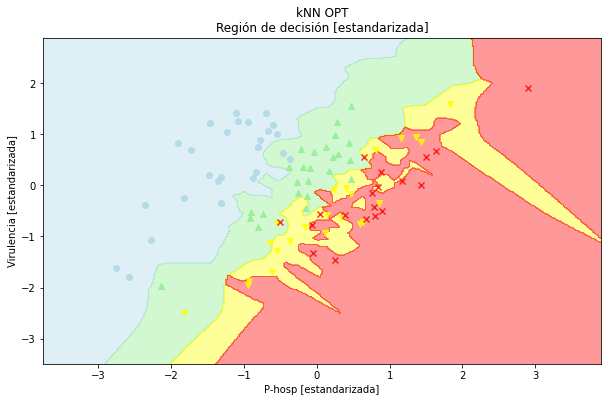

In [33]:
plot_decision_regions(X_test_knn_std, y_test_knn, knn)

#### IV.4. Matrices de confusión. 

In [159]:
def confusion(X_train_svm_std, y_train_svm, X_test_svm_std, y_test_svm, X_train_knn_std, y_train_knn, X_test_knn_std, y_test_knn, cl1, cl2):
    
    # Guardamos los nombres para los ejes
    print('Ingresa el nombre del eje X\n')
    etX = input()
    print('\nIngresa el nombre del eje Y\n')
    etY = input()
    print('\n¿Se ha optimizado el clasificador?\n SI = 1\n NO = 0')
    #esto solo es para  efectuar el etiquetado correcto del nombre de la imagen
    op = input()
    
    if op == '0':
        tipo_op = '\nAlgoritmos NO optimizados'
        t_op = 'NONOp'
    elif op == '1':
        tipo_op = '\nAlgoritmos Optimizados'
        t_op = 'Opt'
    
    filelbl = '{0}_{1}-{2}'.format(t_op, etY, etX)
    
    c_svm = cl1.fit(X_train_svm_std, y_train_svm)
    svm_cm=confusion_matrix(y_test_svm, c_svm.predict(X_test_svm_std))

    c_knn = cl2.fit(X_train_knn_std, y_train_knn)
    knn_cm=confusion_matrix(y_test_knn, c_knn.predict(X_test_svm_std))
    
    plt.figure(figsize=(15,6))
    plt.suptitle("Matrices de confusión {0}".format(tipo_op),fontsize=12)

    ax1 = plt.subplot(1,2,1)
    plt.title("SVM para {0} - {1}".format(etY, etX))
    ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels'); 
    ax1.xaxis.set_ticklabels(['Bajo', 'Intermedio', 'Alto', 'Muy Alto']); ax1.yaxis.set_ticklabels(['Bajo', 'Intermedio', 'Alto', 'Muy Alto']);
    sns.heatmap(svm_cm, annot = True, cmap="Greens",cbar=False);

    ax2 = plt.subplot(1,2,2)
    ax2.set_xlabel('Predicted labels');ax2.set_ylabel('True labels'); 
    ax2.xaxis.set_ticklabels(['Bajo', 'Intermedio', 'Alto', 'Muy Alto']); ax2.yaxis.set_ticklabels(['Bajo', 'Intermedio', 'Alto', 'Muy Alto']);
    plt.title("k-NN para {0} - {1}".format(etY, etX))
    sns.heatmap(knn_cm, annot = True, cmap="Blues",cbar=False);
    
    plt.savefig('Clas_ConfMatrix-{0}.png'.format(filelbl))

Ingresa el nombre del eje X

Suma de distancias 

Ingresa el nombre del eje Y

Proporción de hospitalizados

¿Se ha optimizado el clasificador?
 SI = 1
 NO = 0
1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


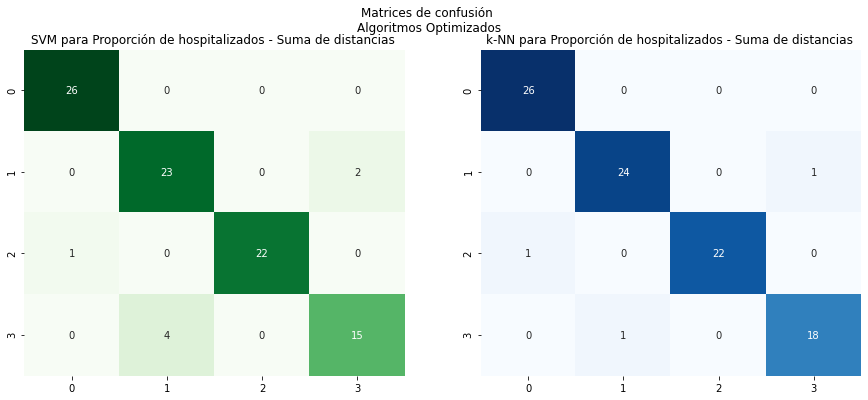

In [160]:
# generamos la matriz de confusión.
confusion(X_train_svm_std, y_train_svm, X_test_svm_std, y_test_svm, X_train_knn_std, y_train_knn, X_test_knn_std, y_test_knn, svm, knn)

### V. Optimización de algoritmos de clasificación. 

Para optimizar el algoritmo de SVM, usamos `GridSearchCV` de `sklearn`. 

#### V.1. Clasificador SVM (Optimizado).


In [44]:
# Definimos la malla de parámetros
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma':[1, 0.1, 0.01, 0.001, 0.0001], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

In [45]:
# Corremos la función GridSearchCV, con la malla como argumento
grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=3)

In [ ]:
#echamos a andar el algoritmo
grid_svm.fit(X_train_svm, y_train_svm)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [ ]:
#pedimos que nos devuelva los mejores parámetros
print("Mejor precisión conseguida:",grid_svm.best_score_)
print("Mejores parámetros:", grid_svm.best_params_)

In [124]:
#optimizamo con los parámetros propuestos
svm_op = SVC(kernel='rbf', random_state=0, gamma=1, C=1000)
svm_op.fit(X_train_svm_std, y_train_svm)

print('La precisión del clasificador SVM con los datos de entrenamiento, es {:.2f} de 1'.format(svm_op.score(X_train_svm_std, y_train_svm)))
print('La precisión del clasificador SVM con los datos de prueba, es {:.2f} de 1'.format(svm_op.score(X_test_svm_std, y_test_svm)))

La precisión del clasificador SVM con los datos de entrenamiento, es 0.87 de 1
La precisión del clasificador SVM con los datos de prueba, es 0.77 de 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Regiones de decisión

Ingresa el nombre del eje X

Proporción de hospitalizaciones

Ingresa el nombre del eje Y

Virulencia

¿Se ha optimizado el clasificador?
 SI = 1
 NO = 0
1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

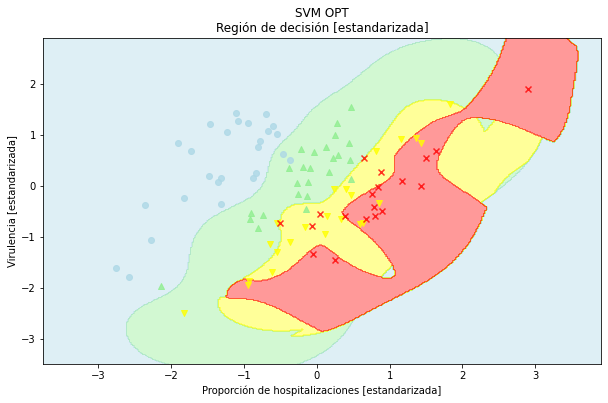

In [126]:
plot_decision_regions(X_test_svm_std, y_test_svm, svm_op)

#### V.2. Clasificador kNN (Optimizado).

Una forma de optimizar, es a partir de encontrar únicamente el número de vecinos k que determine la mejor precisión del clasificador,

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == 

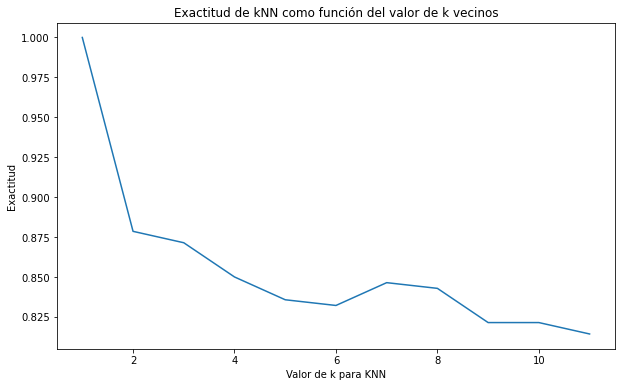

In [79]:
# determinar cuál es el mejor valor de n

k_range = list(range(1,12)) #creamos una lista con 26 valores posibles para k
scores = [] #una variable vacía para almacenar 

for k in k_range:
    #knn = KNeighborsClassifier(n_neighbors=k)
    knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    knn.fit(X, y)
    y_pred = knn.predict(X)
    #scores.append(metrics.accuracy_score(y, y_pred))
    scores.append(metrics.accuracy_score(y, y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('Valor de k para KNN')
plt.ylabel('Exactitud')
plt.title('Exactitud de kNN como función del valor de k vecinos')
plt.show()

In [153]:
# una forma alternativa de escribir los parámetros para la malla
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan", "minkowski"] # el tipo de métrica para calcular la distancia

# la malla
param_grid_knn = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)

# Corremos la función GridSearchCV, con la malla como argumento
grid_knn = GridSearchCV(estimator=knn,param_grid=param_grid_knn,scoring="accuracy", cv=10)
grid_knn.fit(X_train_knn, y_train_knn)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=11),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [154]:
#pedimos que nos devuelva los mejores parámetros

print("Mejor precisión conseguida:",grid_knn.best_score_)
print("Mejores parámetros:", grid_knn.best_params_)

Mejor precisión conseguida: 0.7321637426900585
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [125]:
# corremos la optimización: 
knn_op = KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
knn_op.fit(X_train_knn, y_train_knn)
#y_pred = knn.predict(X_test)

print('La precisión del clasificador SVM con los datos de entrenamiento, es {:.2f} de 1'.format(knn_op.score(X_train_knn_std, y_train_knn)))
print('La precisión del clasificador SVM con los datos de prueba, es {:.2f} de 1'.format(knn_op.score(X_test_knn_std, y_test_knn)))

La precisión del clasificador SVM con los datos de entrenamiento, es 0.43 de 1
La precisión del clasificador SVM con los datos de prueba, es 0.43 de 1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Visualización de las regiones de decisión

Ingresa el nombre del eje X

P-hosp
Ingresa el nombre del eje Y

Virulencia


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

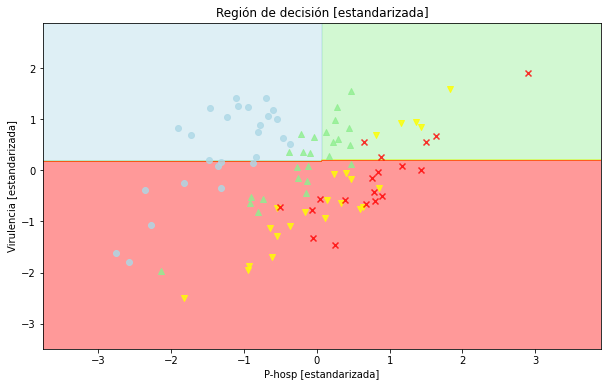

In [101]:
plot_decision_regions(X_test_knn_std, y_test_knn, knn_op)

Optimización alternativa


In [122]:
#knn = KNeighborsClassifier(n_neighbors=2, p=2, metric='minkowski')
#knn.fit(X_train_knn_std, y_train_knn)

# una forma alternativa de escribir los parámetros para la malla
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
weights = ["distance"]#, "distance"]
metric = ["minkowski"] # el tipo de métrica para calcular la distancia
p = [1, 2, 3]

# la malla
param_grid_knn2 = dict(n_neighbors=n_neighbors, weights=weights, metric=metric, p=p)
# Corremos la función GridSearchCV, con la malla como argumento
grid_knn2 = GridSearchCV(estimator=knn ,param_grid=param_grid_knn2, scoring="accuracy", cv=10)
grid_knn2.fit(X_train_knn, y_train_knn)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=11),
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'p': [1, 2, 3], 'weights': ['distance']},
             scoring='accuracy')

In [123]:
#pedimos que nos devuelva los mejores parámetros

print("Mejor precisión conseguida:        ",grid_knn2.best_score_)
print("Mejores parámetros:                ", grid_knn2.best_params_)

Mejor precisión conseguida:         0.7321637426900585
Mejores parámetros:                 {'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [124]:
# corremos la optimización: 
knn_op2 = KNeighborsClassifier(metric='minkowski', n_neighbors=1, weights='uniform', p=2)
knn_op2.fit(X_train_knn, y_train_knn)
#y_pred = knn.predict(X_test)

print('La precisión del clasificador SVM con los datos de entrenamiento, es {:.2f} de 1'.format(knn_op2.score(X_train_knn_std, y_train_knn)))
print('La precisión del clasificador SVM con los datos de prueba, es {:.2f} de 1'.format(knn_op2.score(X_test_knn_std, y_test_knn)))

La precisión del clasificador SVM con los datos de entrenamiento, es 0.50 de 1
La precisión del clasificador SVM con los datos de prueba, es 0.47 de 1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Ingresa el nombre del eje X

XXN
Ingresa el nombre del eje Y

VV


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

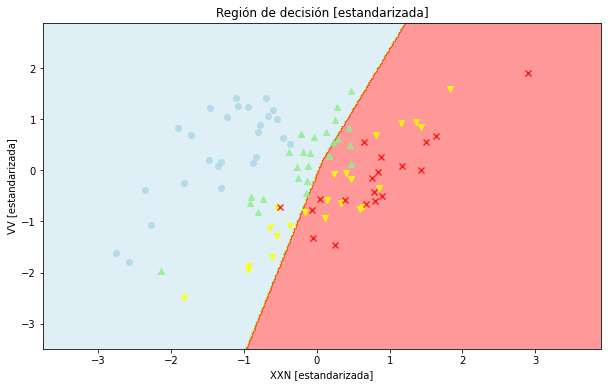

In [125]:
plot_decision_regions(X_test_knn_std, y_test_knn, knn_op2)

### VI. Predicción. 

El dataset es el archivo de ```LOG-X.csv``` 

In [161]:
data_v = pd.read_csv("LOG-X-clasificacion.csv")
print(data_v.shape)
data_v.head()


(54, 11)


,Incidencia,Virulencia,P-hosp,Letalidad,Acumulado hosp,sDist,N decesos infección,N decesos hosp,Acumulado defunciones,atpi,NvProp
0,0.339748,0.193426,0.078240,0.034210,4096,1840276193,529,289,818,44821120,X
1,0.343153,0.190718,0.077038,0.034611,4228,1839781439,588,286,874,45500559,X
2,0.343396,0.188678,0.076523,0.032796,4151,1841055679,532,282,814,45439954,X
3,0.341585,0.188153,0.075349,0.033471,3924,1846273222,545,250,795,43598534,X
4,0.344792,0.188248,0.076420,0.032690,4034,1843685285,544,251,795,43864192,X


Seleccionamos las variables con las que efectuaremos la predicción. 

In [162]:
Pred = data_v.iloc[:, [Ax, Ay]]
#X_pred.to_csv("X_pred.csv")
print(Pred.shape)
Pred.head()

(54, 2)


,sDist,P-hosp
0,1840276193,0.078240
1,1839781439,0.077038
2,1841055679,0.076523
3,1846273222,0.075349
4,1843685285,0.076420


Determinemos las estadísticas de los parámetros de interés. 

In [163]:
# para las variables crudas
a = Pred.describe()
a

,sDist,P-hosp
count,5.400000e+01,54.000000
mean,1.841842e+09,0.076529
std,3.180396e+06,0.001106
min,1.833720e+09,0.074265
25%,1.840122e+09,0.075756
50%,1.841312e+09,0.076549
75%,1.843888e+09,0.077343
max,1.850257e+09,0.079015


In [164]:
P = a.iloc[[5], :]
P

,sDist,P-hosp
50%,1.841312e+09,0.076549


Efectuamos la predicción de cuatro formas distintas:
    
a) **Con los datos crudos**

b) **Con los datos escalados**

c) **Con la mediana (cuartil 50%) como *medida resumen* datos crudos**

In [165]:
X_pred_res = pd.DataFrame(columns=["sDist", "P-hosp"], data=[[1.841312e+09, 0.076549]])
X_pred_res

,sDist,P-hosp
0,1.841312e+09,0.076549


In [166]:
# usando KNN
knn.predict(X_pred_res)

array([4], dtype=int64)

In [167]:
# usando svm
svm.predict(X_pred_res)

array([4], dtype=int64)

d) **Con la mediana (cuartil 50%) como *medida resumen* datos escalados**

In [55]:
X_std_res = pd.DataFrame(columns=["atpi", "P-hosp"], data=[[0.146064, 0.018304]])
X_std_res

,atpi,P-hosp
0,0.146064,0.018304


In [56]:
# usando kNN
knn.predict(X_std_res)

array([3], dtype=int64)

In [57]:
# usando svm
svm.predict(X_std_res)

array([3], dtype=int64)

**Grafica del valor predicho** 

In [91]:
#import warnings 

def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_predicted(X, y, Xp, classifier, test_idx=None, resolution=0.02):
    # Guardamos los nombres para los ejes
    print('Ingresa el nombre del eje X\n')
    etiquetaX = input()
    print('\nIngresa el nombre del eje Y\n')
    etiquetaY = input()
    print('\n¿Se ha optimizado el clasificador?\n SI = 1\n NO = 0')
    #esto solo es para  efectuar el etiquetado correcto del nombre de la imagen
    op = input()
    
    if str(type(classifier)) == "<class 'sklearn.neighbors._classification.KNeighborsClassifier'>" and op == '0':
        name = "kNN NON-Op"
    elif str(type(classifier)) == "<class 'sklearn.svm._classes.SVC'>" and op == '0':
        name = "SVM NON-Op"
    elif str(type(classifier)) == "<class 'sklearn.neighbors._classification.KNeighborsClassifier'>" and op == '1':
        name = "kNN OPT"
    elif str(type(classifier)) == "<class 'sklearn.svm._classes.SVC'>" and op == '1':
        name = "SVM OPT"

    #ambas variables, las convertiremos a objetos de tipo arreglo de numpy
    X = np.asarray(X)
    Xp = np.asarray(Xp)
    y = y['NvProp'].values.tolist()
    
    # setup marker generator and color map
    #markers = ('s', 'x', 'o', '^', 'v')
    #colors = ('red', 'yellow', 'lightgreen', 'lightblue', 'cyan')
    markers = ('o', '^', 'v', 'x', 's')
    colors = ('lightblue', 'lightgreen', 'yellow', 'red', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.xlabel('{0} [estandarizada]'.format(etiquetaX))
    plt.ylabel('{0} [estandarizada]'.format(etiquetaY))
    plt.title('{0}\nRegión de decisión [estandarizada]'.format(name))

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
    plt.scatter( x = Xp[0,0], y = Xp[0,1], marker = 's', color = 'b')
    cp = plt.Circle((Xp[0,0], Xp[0,1]), 1.00939, color = 'b', alpha = 0.3)
    
    plt.gcf().gca().add_artist(cp)
        
    filelabel = "_{0}-{1}".format(etiquetaY, etiquetaX)
    plt.savefig("ClasPred_{0}_{1}.png".format(name, filelabel))
    #print("----IMPORTANTE----\nRevise la carpeta destino de la figura guardada\npara modificar manualmente el nombre y evitar que se sobreescriba.")

Ingresa el nombre del eje X

x

Ingresa el nombre del eje Y

y

¿Se ha optimizado el clasificador?
 SI = 1
 NO = 0
0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

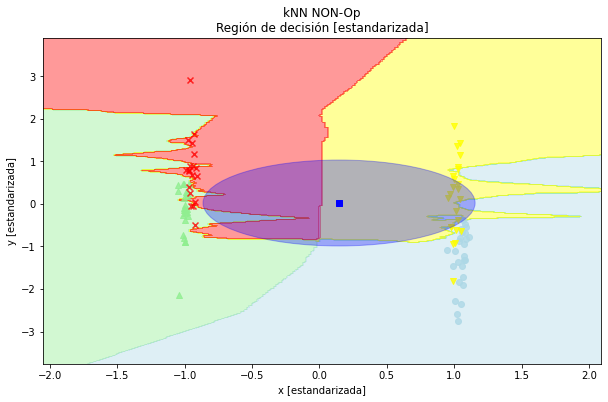

In [92]:
plot_predicted(X_test_knn_std, y_test_knn, X_std_res, knn)

In [82]:
X20 = np.asarray(X_std)
X20

array([[-0.12708486,  1.56022256],
       [ 0.74934833,  0.46405138],
       [ 0.67117173, -0.00560452],
       [-1.70414321, -1.0772049 ],
       [-1.36146125, -0.09943133],
       [-0.11971029, -0.8138246 ],
       [ 1.19863194,  1.50325012],
       [ 1.67045331,  0.53528061],
       [ 0.15124604, -0.24051685],
       [-1.53738408,  0.10252653],
       [-0.54272305,  0.01088731],
       [-2.28837481, -1.11424538],
       [ 0.97686476,  0.75927228],
       [ 0.54012192, -0.80000021],
       [ 0.03943305,  0.93046327],
       [-1.5456113 ,  1.06778754],
       [ 0.57535008, -1.06043118],
       [ 1.2544075 , -0.41371481],
       [ 1.038258  , -0.23233206],
       [ 1.01483146,  0.66577296],
       [-0.26321573,  1.82271341],
       [ 0.53769168,  0.46199697],
       [ 0.51176137,  0.09618176],
       [-1.33204037, -1.14367852],
       [ 2.29424985,  0.76591444],
       [ 0.29136152,  1.27409232],
       [ 0.32240256, -1.94016056],
       [-0.05596034,  0.6061422 ],
       [ 0.04447283,